In [1]:
import xmltodict
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import spacy
%matplotlib inline

## Imports from external classes
from classes.Bio_labeller import get_bio
from classes.Adding_features import add_feature
from classes.Sentence_iterator import iterate_sentence
from classes.Data_loader import load_data
from classes.Featuring import sentence_to_features,sentence_to_labels,sentence_to_tokens,word_to_features

In [2]:
'''Using spacy library since it is the industry standard most powerful 
open-source library with multitude apis for various text processings '''
nlp = spacy.load('en_core_web_lg')

In [3]:
training_dataset = "/Users/agni/Desktop/pmi/aspect-term-extractor-and-classifier/datasets/Laptops_Train_v2.xml"
testing_dataset = "/Users/agni/Desktop/pmi/aspect-term-extractor-and-classifier/datasets/Laptops_Test_Gold.xml"

In [4]:
nlp = spacy.load('en_core_web_lg')

In [5]:
training_df = add_feature(load_data(training_dataset, nlp))

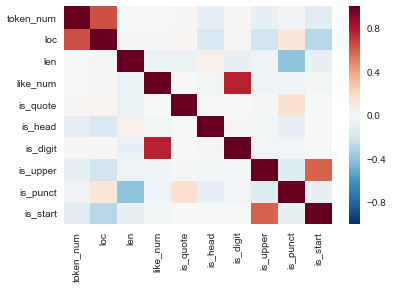

In [6]:
sns.heatmap(training_df.corr())

In [7]:
training_df.head(2)

,id,token,label,all_aspects,text,bin_label,token_num,loc,len,pos,lemma,like_num,is_quote,is_head,is_digit,is_upper,is_punct,is_start
0,2339,I,O,"[cord, battery life]",I charge it at night and skip taking the cord ...,O,19,0,1,PRON,-PRON-,False,False,False,False,True,False,True
1,2339,charge,O,"[cord, battery life]",I charge it at night and skip taking the cord ...,O,19,1,6,VERB,charge,False,False,True,False,False,False,False


In [8]:
print(" Frequency of occurence of aspect term in sentences")
count_aspect_term = lambda labels: len([l for l in labels if l=="B" ])
label_count = training_df.groupby("id").agg({"label": count_aspect_term}).reset_index()
label_count.groupby("label").count()


 Frequency of occurence of aspect term in sentences


,id
label,
0,1559
1,930
2,352
3,140
4,43
5,10
6,6
7,3
8,1


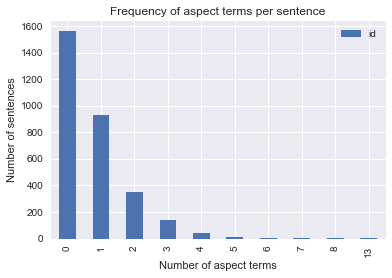

In [9]:
fig_aspect_term_distribution = label_count.groupby("label").count().plot.bar()
fig_aspect_term_distribution.set_title("Frequency of aspect terms per sentence")
fig_aspect_term_distribution.set_ylabel("Number of sentences")
fig_aspect_term_distribution.set_xlabel("Number of aspect terms")

The above graph shows the distribution spread of the occurence of aspect terms in the training dataset. It is clearly visible
that majority of the sentences are without an aspect term. Only around 1487 sentences out of 3045 sentences, ie, 48.8%
sentences have the occurence of an aspect term in them. 

##### We get to see a sentence having 13 aspect terms. Lets see what are the terms and the what is the sentence

In [10]:
id_labels = label_count[label_count.label==13]["id"].values[0]
row = training_df[training_df.id==id_labels].head(3)[["text", "all_aspects"]]

In [11]:
print("The text is :: \n")
row.iloc[0]["text"]

The text is :: 



'There are several programs for school or office use (Pages, Numbers, Keynote, etc.), music (Garageband), photo management (Photo Booth, iPhoto), video-editing or movie-making (iMovie), etc.'

In [12]:
print("The aspect terms are :: \n")
row.iloc[0]["all_aspects"]

The aspect terms are :: 



['programs',
 'Garageband',
 'Photo Booth',
 'iPhoto',
 'iMovie',
 'video-editing',
 'movie-making',
 'photo management',
 'music',
 'Pages',
 'Numbers',
 'Keynote',
 'school or office use']

### Building the model for classification

In [13]:
train_sentence_aspects_tuple = list(iterate_sentence(training_dataset, nlp))
test_sentence_aspects_tupe = list(iterate_sentence(testing_dataset, nlp))
train_sentence = [list(zip(sentence[0], sentence[4])) for sentence in train_sentence_aspects_tuple]
test_sentence = [list(zip(sentence[0], sentence[4])) for sentence in test_sentence_aspects_tupe]

In [14]:
X_train = [sentence_to_features(sentence) for sentence in train_sentence]
y_train = [sentence_to_labels(sentence) for sentence in train_sentence]

X_test = [sentence_to_features(sentence) for sentence in test_sentence]
y_test = [sentence_to_labels(sentence) for sentence in test_sentence]

### Importing machine learning models for training and testing

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn_crfsuite import CRF

### Importing libraries for evaluation and validation of the model testing

In [16]:
from sklearn_crfsuite import metrics
from sklearn.model_selection import cross_val_score

In [17]:
rf = RandomForestClassifier()
gb = GaussianNB()
ds = DecisionTreeClassifier()

### Testing with Conditional Random Field

This model has been chosen based on the following article: 
http://www.albertauyeung.com/post/python-sequence-labelling-with-crf/

In [18]:
crf = CRF(
    algorithm='lbfgs',
    c1=1.0,
    c2=1.0,
    max_iterations=100,
    all_possible_transitions=True
)

In [19]:
crf.fit(X_train, y_train)

CRF(algorithm='lbfgs', all_possible_states=None,
  all_possible_transitions=True, averaging=None, c=None, c1=1.0, c2=1.0,
  calibration_candidates=None, calibration_eta=None,
  calibration_max_trials=None, calibration_rate=None,
  calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
  gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
  max_linesearch=None, min_freq=None, model_filename=None,
  num_memories=None, pa_type=None, period=None, trainer_cls=None,
  variance=None, verbose=False)

In [20]:
y_pred_crf = crf.predict(X_test)

In [21]:
print(metrics.flat_classification_report(
    y_test, y_pred_crf, labels=["B", "I" ], digits=2 ))

             precision    recall  f1-score   support

          B       0.85      0.66      0.74       652
          I       0.90      0.61      0.73       462

avg / total       0.87      0.64      0.74      1114



In [22]:
all_features = set([attributes for (attributes, values) in crf.state_features_])

In [23]:
from pycrfsuite import ItemSequence
def vectorize_sentences(sentence, feature_index):
    sentence_features = ItemSequence(sentence).items()
    result = []
    for token_feature in sentence_features:
        result.append([token_feature.get(feature, 0) for feature in feature_index])
    return result

In [24]:
def flatten(sent):
    return [t for tokens in sent for t in tokens]

In [25]:
feature_index = sorted(list(all_features))

In [26]:
X_train_vec = [vectorize_sentences(feature_dict, feature_index) for feature_dict in X_train]
X_test_vec = [vectorize_sentences(feature_dict, feature_index) for feature_dict in X_test]

In [27]:
X_train_vec_flat = flatten(X_train_vec)
X_test_vec_flat = flatten(X_test_vec)

y_train_flat = flatten(y_train)
y_test_flat = flatten(y_test)

### Testing with Random Forest

In [28]:
rf.fit(X_train_vec_flat, y_train_flat)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [29]:
random_forest_y_pred = rf.predict(X_test_vec_flat)

In [30]:
print(metrics.flat_classification_report(
    y_test, random_forest_y_pred, labels=["B", "I"], digits=2))

             precision    recall  f1-score   support

          B       0.72      0.65      0.69       652
          I       0.76      0.35      0.48       462

avg / total       0.74      0.53      0.60      1114



### Testing with Naive Bayes

In [31]:
gb.fit(X_train_vec_flat, y_train_flat)

GaussianNB(priors=None)

In [32]:
naive_bayes_y_pred = gb.predict(X_test_vec_flat)

In [33]:
print(metrics.flat_classification_report(
    y_test, naive_bayes_y_pred, labels=["B", "I"], digits=2))

             precision    recall  f1-score   support

          B       0.17      0.94      0.29       652
          I       0.23      0.55      0.33       462

avg / total       0.19      0.78      0.30      1114



### Testing with decision tree

In [34]:
ds.fit(X_train_vec_flat, y_train_flat)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [35]:
decision_tree_y_pred = ds.predict(X_test_vec_flat)

In [36]:
print(metrics.flat_classification_report(
    y_test, decision_tree_y_pred, labels=["B", "I"], digits=2))

             precision    recall  f1-score   support

          B       0.67      0.64      0.66       652
          I       0.67      0.43      0.53       462

avg / total       0.67      0.56      0.60      1114



### Using ensemble approach

In [37]:
vote_stacking = VotingClassifier(estimators=[
               ('rf', RandomForestClassifier()), 
                ('ds', DecisionTreeClassifier()), 
                 ],
    voting='hard') 

In [38]:
vote_stacking.fit(X_train_vec_flat, y_train_flat)

VotingClassifier(estimators=[('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_we...      min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))],
         flatten_transform=None, n_jobs=1, voting='hard', weights=None)

In [39]:
vote_stacking_y_pred = vote_stacking.predict(X_test_vec_flat)

In [40]:
print(metrics.flat_classification_report(
    y_test, vote_stacking_y_pred, labels=["B", "I"], digits=2))

             precision    recall  f1-score   support

          B       0.64      0.72      0.68       652
          I       0.67      0.41      0.51       462

avg / total       0.65      0.59      0.61      1114



### Estimating performance using K-Fold Cross Validation

[0.93830895948898974, 0.94301427425734052, 0.9457892208665577, 0.94629208971590839, 0.94704868660319474, 0.94654393404881554, 0.94847723598818723, 0.94897865889471467, 0.94847541267002122]


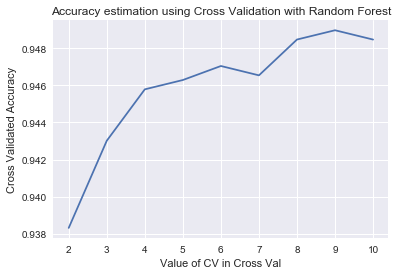

In [41]:
cv_range =  list(range(2, 11))
k_scores = []
for cv in cv_range:
    scores = cross_val_score(rf ,X_test_vec_flat, y_test_flat, cv=cv, scoring='accuracy')
    k_scores.append(scores.mean())
    
print(k_scores)
plt.plot(cv_range, k_scores)
plt.xlabel('Value of CV in Cross Val')
plt.ylabel('Cross Validated Accuracy')
plt.title('Accuracy estimation using Cross Validation with Random Forest')

[0.92427298705664818, 0.9304905460087175, 0.93326558464677056, 0.93208662677226428, 0.93595370492719432, 0.93612218202012054, 0.93679364973068235, 0.93687405766589293, 0.93544531883570359]


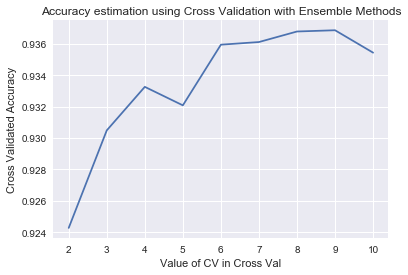

In [42]:
cv_range =  list(range(2, 11))
k_scores = []
for cv in cv_range:
    scores = cross_val_score(vote_stacking ,X_test_vec_flat, y_test_flat, cv=cv, scoring='accuracy')
    k_scores.append(scores.mean())
    
print(k_scores)
plt.plot(cv_range, k_scores)
plt.xlabel('Value of CV in Cross Val')
plt.ylabel('Cross Validated Accuracy')
plt.title('Accuracy estimation using Cross Validation with Ensemble Methods')

[0.95288516161842463, 0.9591810787931726, 0.9574535914772504, 0.96011828966019908, 0.96151720497300575, 0.95887499233056306, 0.96044152810671424, 0.95963458732616325, 0.95862017858922766]


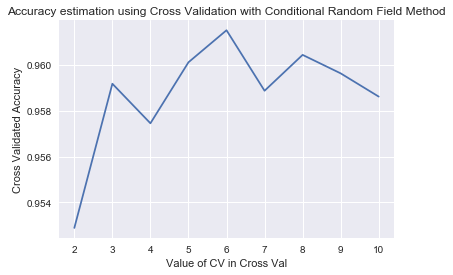

In [43]:
cv_range =  list(range(2, 11))
k_scores = []
for cv in cv_range:
    scores = cross_val_score(crf ,X_test, y_test, cv=cv)
    k_scores.append(scores.mean())
    
print(k_scores)
plt.plot(cv_range, k_scores)
plt.xlabel('Value of CV in Cross Val')
plt.ylabel('Cross Validated Accuracy')
plt.title('Accuracy estimation using Cross Validation with Conditional Random Field Method')